# Neural Receiver for 5G_PUSCH Systems

## GPU Configuration and Imports <a class="anchor" id="GPU-Configuration-and-Imports"></a>

In [2]:
#!git clone https://github.com/1000001111/thanh.git

In [3]:
#!pip install -r /content/thanh/requirements.txt

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


import sys
sys.path.append('../')
import sionna

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42 # Set seed for reproducible random number generation

# Load the required Sionna components
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver, CarrierConfig, PUSCHDMRSConfig,\
                        TBConfig, PUSCHPilotPattern, TBEncoder, PUSCHPrecoder, LayerMapper, LayerDemapper, check_pusch_configs,\
                        TBDecoder, PUSCHLSChannelEstimator
from sionna.nr.utils import generate_prng_seq
from sionna.channel import AWGN, RayleighBlockFading, OFDMChannel, TimeChannel, time_lag_discrete_time_channel
from sionna.channel.utils import *
from sionna.channel.tr38901 import Antenna, AntennaArray, UMi, UMa, RMa, TDL, CDL
from sionna.channel import gen_single_sector_topology as gen_topology
from sionna.utils import compute_ber, ebnodb2no, sim_ber, array_to_hash, create_timestamped_folders, b2b, f2f, BinarySource
from sionna.ofdm import KBestDetector, LinearDetector, MaximumLikelihoodDetector,\
        LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper,\
        ResourceGrid, ResourceGridMapper, OFDMModulator
from sionna.mimo import StreamManagement
from sionna.mapping import Mapper, Demapper

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
# from bs4 import BeautifulSoup
import pickle
from collections import namedtuple
import json
from tqdm import tqdm
import itertools
import io

from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization, SeparableConv2D
from tensorflow.nn import relu

## Simulation Parameters <a class="anchor" id="Simulation-Parameters"></a>

In [7]:
class MyPUSCHConfig(PUSCHConfig):
    def __init__(self):
        super().__init__(
            carrier_config=CarrierConfig(
                n_cell_id=0,
                cyclic_prefix="normal",
                subcarrier_spacing=30,
                n_size_grid=273,
                n_start_grid=0,
                slot_number=4,
                frame_number=0
            ),
            pusch_dmrs_config=PUSCHDMRSConfig(
                config_type=1,
                length=1,
                additional_position=1,
                dmrs_port_set=[0],
                n_id=0,
                n_scid=0,
                num_cdm_groups_without_data=2,
                type_a_position=2
            ),
            tb_config=TBConfig(
                channel_type='PUSCH',
                n_id=0,
                mcs_table=1,
                mcs_index=9
            ),
            mapping_type='A',
            n_size_bwp=273,
            n_start_bwp=0,
            num_layers=1,
            num_antenna_ports=1,
            precoding='non-codebook',
            tpmi=0,
            transform_precoding=False,
            n_rnti=2008,
            symbol_allocation=[0,14]
        )

In [8]:
class ResidualBlock(tf.keras.Model):
    r"""
    This Keras layer implements a convolutional residual block made of two convolutional layers with ReLU activation, layer normalization, and a skip connection.
    The number of convolutional channels of the input must match the number of kernel of the convolutional layers ``num_conv_channel`` for the skip connection to work.

    Input
    ------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Input of the layer

    Output
    -------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Output of the layer
    """

    def build(self, input_shape):

        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = SeparableConv2D(filters= 64,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = SeparableConv2D(filters= 128,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)

    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs

        return z

class CustomNeuralReceiver(tf.keras.Model):
    r"""
    Keras layer implementing a residual convolutional neural receiver.

    This neural receiver is fed with the post-DFT received samples, forming a resource grid of size num_of_symbols x fft_size, and computes LLRs on the transmitted coded bits.
    These LLRs can then be fed to an outer decoder to reconstruct the information bits.

    Input
    ------
    y_no: [batch size, num ofdm symbols, num subcarriers, 2*num rx antenna + 1], tf.float32
        Concatenated received samples and noise variance.
(
    y : [batch size, num rx antenna, num ofdm symbols, num subcarriers], tf.complex
        Received post-DFT samples.

    no : [batch size], tf.float32
        Noise variance. At training, a different noise variance value is sampled for each batch example.
)
    Output
    -------
    : [batch size, num ofdm symbols, num subcarriers, num_bits_per_symbol]
        LLRs on the transmitted bits.
    """

    def __init__(self, training = False):
        super(CustomNeuralReceiver, self).__init__()
        self._training = training

    def build(self, input_shape):

        # Input convolution
        self._input_conv = Conv2D(filters= 128,
                                  kernel_size=[3,3],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters= 2,    # QPSK
                                   kernel_size=[3,3],
                                   padding='same',
                                   activation=None)
        

    @tf.function(jit_compile=True)
    def call(self, inputs):
        # Input conv
        z = self._input_conv(inputs)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)
        # if self._training == False:
        #     z = tf.cast(z * (2**7), tf.int8)
        return z

# Init Neural model and load weights

In [9]:
_model = CustomNeuralReceiver(training = False)
inputs = tf.zeros([1,3276,14,16])
_model(inputs)
_model.summary()

def load_weights(model, pretrained_weights_path):
    # Build Model with random input
    # Load weights
  with open(pretrained_weights_path, 'rb') as f:
    weights = pickle.load(f)
    model.set_weights(weights)
    print(f"Loaded pretrained weights from {pretrained_weights_path}")

#load_weights(_model, '/content/drive/MyDrive/Pusch_data/Model_weights/model_weight_FULL_RB_epoch_40.pkl')
load_weights(_model, '../model_weight_FULL_RB_epoch_40.pkl')


I0000 00:00:1741061185.580881   65921 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Model: "custom_neural_receiver"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  18560     
                                                                 
 residual_block (ResidualBl  multiple                  17630080  
 ock)                                                            
                                                                 
 residual_block_1 (Residual  multiple                  17630080  
 Block)                                                          
                                                                 
 residual_block_2 (Residual  multiple                  17630080  
 Block)                                                          
                                                                 
 residual_block_3 (Residual  multiple                  17630080  
 Block)                                     

# Convert model to OpenVino IR

In [10]:
import openvino as ov

#from torchvision.models import resnet50

   #model = resnet50(weights='DEFAULT')

   # prepare input_data
   #input_data = torch.rand(1, 3, 224, 224)

ov_model = ov.convert_model(_model, example_input=inputs)

   ###### Option 1: Save to OpenVINO IR:

   # save model to OpenVINO IR for later use
ov.save_model(ov_model, 'model.xml')

   ###### Option 2: Compile and infer with OpenVINO:

   # compile model
compiled_model = ov.compile_model(ov_model)

   # run inference
result = compiled_model(inputs)
result[0]


<frozen importlib.util>:262: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.


array([[[[ 0.3939997 , -0.05573409],
         [ 0.7757572 , -0.15939957],
         [-1.6568781 , -1.097502  ],
         ...,
         [-1.0393625 , -3.2531435 ],
         [ 0.40549448, -0.8001056 ],
         [ 0.7092933 , -0.38994855]],

        [[-0.64249897, -0.20498112],
         [-0.359975  , -0.47925454],
         [ 0.4042289 , -2.483864  ],
         ...,
         [ 1.0422474 , -1.489001  ],
         [-0.1686385 ,  0.20393814],
         [-0.5961334 , -0.24306473]],

        [[ 0.47181806, -0.2825075 ],
         [-0.34960198, -0.82458735],
         [-1.0223565 ,  2.4616966 ],
         ...,
         [-0.17546593, -0.86788493],
         [-0.95803386,  0.5714627 ],
         [-0.87323254,  0.1301469 ]],

        ...,

        [[-1.1971776 ,  0.22087635],
         [ 1.250795  , -0.765727  ],
         [-1.6010128 ,  0.53846663],
         ...,
         [-0.7708834 , -1.4260383 ],
         [ 0.5898493 ,  0.9326638 ],
         [ 0.15485309, -0.11324564]],

        [[ 0.286517  ,  0.12908489

## Ex using model OpenVINI IR

In [11]:
# load TensorFlow model into memory
#model = tf.keras.applications.MobileNetV2(weights='imagenet')

# compile the model for CPU device
core = ov.Core()
model_path = "model.xml"
_compiled_model = core.compile_model(model_path, "CPU")

# infer the model on random data
#data = np.random.rand(1, 224, 224, 3)
data = inputs
output = _compiled_model({0: data})
output[0]

array([[[[ 0.39390624, -0.05596012],
         [ 0.77519274, -0.1605895 ],
         [-1.6581422 , -1.0985881 ],
         ...,
         [-1.0374254 , -3.2541742 ],
         [ 0.40688255, -0.7985105 ],
         [ 0.71148235, -0.39119974]],

        [[-0.64054406, -0.20438938],
         [-0.3592171 , -0.48143938],
         [ 0.40506974, -2.4830797 ],
         ...,
         [ 1.0431923 , -1.4864529 ],
         [-0.16814993,  0.20761655],
         [-0.5941537 , -0.24314044]],

        [[ 0.47689408, -0.28358778],
         [-0.34801844, -0.82276726],
         [-1.0285642 ,  2.4609706 ],
         ...,
         [-0.17467637, -0.86547804],
         [-0.9578968 ,  0.57385236],
         [-0.8735329 ,  0.13104126]],

        ...,

        [[-1.1956743 ,  0.22661354],
         [ 1.2526906 , -0.76119214],
         [-1.6058835 ,  0.5422636 ],
         ...,
         [-0.77287686, -1.4233642 ],
         [ 0.58855057,  0.9331155 ],
         [ 0.1559486 , -0.11095528]],

        [[ 0.28755563,  0.13233492

# Create End-to-end Simulation Model 

In [28]:
# We need to enable sionna.config.xla_compat before we can use
# tf.function with jit_compile=True.
# See https://nvlabs.github.io/sionna/api/config.html#sionna.Config.xla_compat
sionna.config.xla_compat=True

class Model(tf.keras.Model):
    def __init__(self, decoding_scenario, channel_scenario):
        super().__init__()

        assert decoding_scenario in ['perfect-csi', 'ls-without-prior', 'neural-receiver', 'openvino-model']
        self.decoding_scenario = decoding_scenario
        channel_scenario = channel_scenario.split('-')
        assert len(channel_scenario) == 4
        (chnl, ml, ds, spd) = channel_scenario
        ds = int(ds)
        spd = int(spd)
        assert chnl == 'CDL'

        self._pusch_config = MyPUSCHConfig()
        self._pusch_config.tb.mcs_index = 3


        self._tb_size = self._pusch_config.tb_size
        self._num_coded_bits = self._pusch_config.num_coded_bits
        self._target_coderate = self._pusch_config.tb.target_coderate
        self._num_bits_per_symbol = self._pusch_config.tb.num_bits_per_symbol
        _num_layers = self._pusch_config.num_layers
        _n_rnti = self._pusch_config.n_rnti
        _n_id = self._pusch_config.tb.n_id


        self._binary_source = BinarySource(dtype=tf.float32)

        self._tb_encoder = TBEncoder(
                        target_tb_size=self._tb_size,
                        num_coded_bits=self._num_coded_bits,
                        target_coderate=self._target_coderate,
                        num_bits_per_symbol=self._num_bits_per_symbol,
                        num_layers=_num_layers,
                        n_rnti=_n_rnti,
                        n_id=_n_id,
                        channel_type="PUSCH", # PUSCHTransmitter
                        codeword_index=0, # not supported for PUSCH
                        use_scrambler=True,
                        verbose=False,
                        output_dtype=tf.float32)

        self._mapper = Mapper("qam", self._num_bits_per_symbol, dtype=tf.complex64)

        self._layer_mapper = LayerMapper(num_layers=_num_layers, dtype=tf.complex64)

        _dmrs_length = self._pusch_config.dmrs.length
        _dmrs_additional_position = self._pusch_config.dmrs.additional_position
        _num_cdm_groups_without_data = self._pusch_config.dmrs.num_cdm_groups_without_data
        _n_scid = self._pusch_config.dmrs.n_scid
        _n_id_n_scid = self._pusch_config.dmrs.n_id[0]

        _pilot_pattern = PUSCHPilotPattern([self._pusch_config],
                                                dtype=tf.complex64)
        _mu = 1
        _num_ofdm_symbols = 14
        _fft_size = 4096
        _cyclic_prefix_length = 288
        _subcarrier_spacing = 30e3
        _num_guard_subcarriers = (410, 410)
        _num_slots_per_frame = 20

        # Define the resource grid.
        self._resource_grid = ResourceGrid(
            num_ofdm_symbols=_num_ofdm_symbols,
            fft_size=_fft_size,
            subcarrier_spacing=_subcarrier_spacing,
            num_tx=1,
            num_streams_per_tx=1,
            cyclic_prefix_length=_cyclic_prefix_length,
            num_guard_carriers=_num_guard_subcarriers,
            dc_null=False,
            pilot_pattern=_pilot_pattern,
            dtype=tf.complex64
        )

        self._resource_grid_mapper = ResourceGridMapper(self._resource_grid, dtype=tf.complex64)





        self._num_tx = 1
        _num_rx = 1
        _num_tx_ant = 1
        _num_rx_ant = 8
        _carrier_frequency = 2.55e9  # Carrier frequency in Hz.
        _link_direction = "uplink"
        _rx_tx_association = np.ones([_num_rx, self._num_tx], bool)
        _stream_management = StreamManagement(_rx_tx_association, _num_layers)


        if decoding_scenario in ['neural-receiver', 'openvino-model']:
            self._model = _model
            self.ov_model = _compiled_model
        else:
            if 'ls-without-prior' == decoding_scenario:
                self._channel_estimator = PUSCHLSChannelEstimator(
                                self._resource_grid,
                                _dmrs_length,
                                _dmrs_additional_position,
                                _num_cdm_groups_without_data,
                                interpolation_type='lin',
                                dtype=tf.complex64)

            self._mimo_detector = LinearDetector("lmmse", "bit", "maxlog", self._resource_grid,
                                            _stream_management, "qam",self. _num_bits_per_symbol, dtype=tf.complex64)


        self._layer_demapper = LayerDemapper(self._layer_mapper, num_bits_per_symbol=self._num_bits_per_symbol)
        self._tb_decoder = TBDecoder(self._tb_encoder, output_dtype=tf.float32)




        # Configure antenna arrays
        _ue_antenna = Antenna(polarization="single",
                        polarization_type="V",
                        antenna_pattern="38.901",
                        carrier_frequency=_carrier_frequency)

        _gnb_array = AntennaArray(num_rows=1,
                                num_cols=_num_rx_ant//2,
                                polarization="dual",
                                polarization_type="cross",
                                antenna_pattern="38.901",
                                carrier_frequency=_carrier_frequency)

        self._channel_model = CDL(model = ml,
                                  delay_spread = ds*1e-9,
                                  carrier_frequency = _carrier_frequency,
                                  ut_array = _ue_antenna,
                                  bs_array = _gnb_array,
                                  direction = _link_direction,
                                  min_speed = spd,
                                  max_speed = spd)

        self._channel = OFDMChannel(
                            self._channel_model,
                            self._resource_grid,
                            # normalize_channel=True,
                            return_channel=True)

    def predict_with_model(self, y, batch_size, num_coded_bits, decoding_scenario):
        def prep_y(y):
            # c = tf.transpose(tf.reshape(c, [c.shape[0], 12,-1,2]), perm=[0,2,1,3])
            y = y[...,410:-410]

            # Concat Real and Image of y
            y = tf.concat([tf.math.real(y), tf.math.imag(y)], axis=2)
            y = y[:,0]
            y = tf.transpose(y, perm=[0,3,2,1])
            return y

        # y.shape, c.shape
        y_prep = prep_y(y)
        if 'neural-receiver' == decoding_scenario:
            pred = self._model(y_prep)
        elif 'openvino-model' == decoding_scenario:
            pred = self.ov_model({0:y_prep})[0]
        pred = tf.concat([pred[...,0:2,:], pred[...,3:11,:], pred[...,12:14,:]],axis=-2)
        pred = tf.transpose(pred, perm=[0,2,1,3])
        c_pred = tf.reshape(pred, [batch_size,1,1,num_coded_bits])

        return c_pred

    # def new_topology(self, batch_size):
    #     """Set new topology"""
    #     topology = gen_topology(batch_size,
    #                             self._num_tx,
    #                             'umi',
    #                             min_ut_velocity=0,
    #                             max_ut_velocity=0)

    #     self._channel_model.set_topology(*topology)

    # @tf.function(jit_compile=True)
    def call(self, batch_size, ebno_db):
        # self.new_topology(batch_size)



        b = self._binary_source([batch_size, self._num_tx, self._tb_size])
        c = self._tb_encoder(b)
        x_map = self._mapper(c)
        x_layer = self._layer_mapper(x_map)
        x = self._resource_grid_mapper(x_layer)


        no = ebnodb2no(ebno_db,
                       self._num_bits_per_symbol,
                       self._target_coderate,
                       self._resource_grid)
        y, h = self._channel([x, no])





        if self.decoding_scenario in ['neural-receiver','openvino-model']:
            llr_det = self.predict_with_model(y, batch_size, self._num_coded_bits, self.decoding_scenario)
        else:
            if 'ls-without-prior' == self.decoding_scenario:
                no_arg = 0.001
                h_hat,err_var = self._channel_estimator([y, no_arg])

            elif 'perfect-csi':
                h_hat = h[...,410:-410]
                no_arg = no
                err_var = tf.cast(0, tf.float32)

            llr_det = self._mimo_detector([y, h_hat, err_var, no_arg])




        llr_layer = self._layer_demapper(llr_det)

        # bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr_layer)
        # bce = tf.reduce_mean(bce)



        b_hat, tb_crc_status = self._tb_decoder(llr_layer)

        return b, b_hat
    
    def compare(self, batch_size, ebno_db, decoding_scenarios):

        b = self._binary_source([batch_size, self._num_tx, self._tb_size])
        c = self._tb_encoder(b)
        x_map = self._mapper(c)
        x_layer = self._layer_mapper(x_map)
        x = self._resource_grid_mapper(x_layer)


        no = ebnodb2no(ebno_db,
                       self._num_bits_per_symbol,
                       self._target_coderate,
                       self._resource_grid)
        y, h = self._channel([x, no])

        b_hat_dict = {}
        for decoding_scenario in decoding_scenarios:
            if decoding_scenario in ['neural-receiver','openvino-model']:
                llr_det = self.predict_with_model(y, batch_size, self._num_coded_bits, decoding_scenario)
            else:
                if 'ls-without-prior' == decoding_scenario:
                    no_arg = 0.001
                    h_hat,err_var = self._channel_estimator([y, no_arg])

                elif 'perfect-csi':
                    h_hat = h[...,410:-410]
                    no_arg = no
                    err_var = tf.cast(0, tf.float32)

                llr_det = self._mimo_detector([y, h_hat, err_var, no_arg])

            llr_layer = self._layer_demapper(llr_det)
            b_hat, tb_crc_status = self._tb_decoder(llr_layer)

            b_hat_dict[decoding_scenario] = b_hat
            
        return b, b_hat_dict

XLA can lead to reduced numerical precision. Use with care.


# Creat and run 1 testcase

In [29]:
e2e = Model('openvino-model', 'CDL-C-150-10')

In [36]:
# Assuming e2e and compute_ber are defined elsewhere
for ebno_db in np.arange(-17., 6., 1.):
    b, b_hat = e2e.compare(batch_size=1, ebno_db=ebno_db, decoding_scenarios=['openvino-model', 'neural-receiver'])
    ov_ber = compute_ber(b, b_hat['openvino-model'])
    nn_ber = compute_ber(b, b_hat['neural-receiver'])
    print(f'ov: {ov_ber:.4f} | nn: {nn_ber:.4f}')
    print('-----------------------')


ov: 0.4277 | nn: 0.4254
-----------------------
ov: 0.4356 | nn: 0.4367
-----------------------
ov: 0.3736 | nn: 0.3742
-----------------------
ov: 0.4395 | nn: 0.4444
-----------------------
ov: 0.4094 | nn: 0.4095
-----------------------
ov: 0.0001 | nn: 0.0001
-----------------------
ov: 0.3096 | nn: 0.2998
-----------------------
ov: 0.3892 | nn: 0.3836
-----------------------
ov: 0.2897 | nn: 0.2850
-----------------------
ov: 0.3127 | nn: 0.3186
-----------------------
ov: 0.3817 | nn: 0.3903
-----------------------
ov: 0.1082 | nn: 0.1136
-----------------------
ov: 0.0000 | nn: 0.0000
-----------------------
ov: 0.0000 | nn: 0.0000
-----------------------
ov: 0.3872 | nn: 0.3782
-----------------------
ov: 0.0000 | nn: 0.0000
-----------------------
ov: 0.0000 | nn: 0.0000
-----------------------
ov: 0.3638 | nn: 0.3604
-----------------------
ov: 0.0000 | nn: 0.0000
-----------------------
ov: 0.0000 | nn: 0.0000
-----------------------
ov: 0.0000 | nn: 0.0000
----------------

# Config and run Simulation

In [ ]:
# Select scenarios for simulation
channel_scenarios = ['CDL-C-150-10']  #     Form: [Channel_type(CDL-A/B/C/D/E)-delay_spread(ns)-speed]
# decoding_scenarios = ['neural-receiver', 'ls-without-prior', 'perfect-csi']
decoding_scenarios = ['neural-receiver', 'openvino-model']



# Custom config (ebno range, batch test, num_target_block_errors, max_mc_iter)
_PUSCH_SIMS = {
    "channel_scenarios": channel_scenarios,
    "decoding_scenarios": decoding_scenarios,
    "bler" : [],
    "ber" : [],
    "ebno_dbs": list(np.arange(-17., 15.1, 4.)),
    "batch_size": 4,
    "num_target_block_errors": 128,
    "max_mc_iter": 100,
    "duration": 0
    }

start = time.time()

for channel_scenario in _PUSCH_SIMS['channel_scenarios']:
    print('Channel scenario: ', channel_scenario)
    for decoding_scenario in _PUSCH_SIMS['decoding_scenarios']:
        print('Decoding_scenario: ', decoding_scenario)
        e2e = Model(decoding_scenario, channel_scenario)
        ber, bler = sim_ber(e2e, _PUSCH_SIMS['ebno_dbs'],
                            batch_size=_PUSCH_SIMS["batch_size"],
                            num_target_block_errors=_PUSCH_SIMS["num_target_block_errors"],
                            max_mc_iter=_PUSCH_SIMS["max_mc_iter"])
        _PUSCH_SIMS["ber"].append(list(ber.numpy()))
        _PUSCH_SIMS["bler"].append(list(bler.numpy()))

_PUSCH_SIMS["duration"] = time.time() - start

Channel scenario:  CDL-C-150-10
Decoding_scenario:  neural-receiver
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -17.0 | 4.6573e-01 | 1.0000e+00 |     1160310 |     2491392 |          128 |         128 |       511.1 |reached target block errors


- Save BER array to file

In [ ]:
name = datetime.now().strftime("%Y%m%d%H%M%S%f")
sim_dir = f'/content/drive/MyDrive/Pusch_data/Pusch_sims/{name}'
os.makedirs(sim_dir,exist_ok=True)
with open(f'{sim_dir}/pusch_sims.pkl', 'wb') as file:
    pickle.dump(_PUSCH_SIMS, file)

* Load BER array

In [ ]:
pre_load_sims = True
if pre_load_sims:
    with open(f'/content/drive/MyDrive/Pusch_data/Pusch_sims/{name}/pusch_sims.pkl', 'rb') as file:
        PUSCH_SIMS = pickle.load(file)
else:
    PUSCH_SIMS = _PUSCH_SIMS

- Plot result

Simulation duration: 0.00 [h]


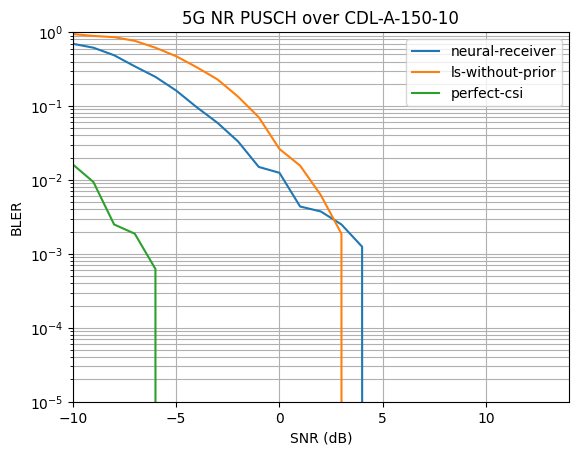

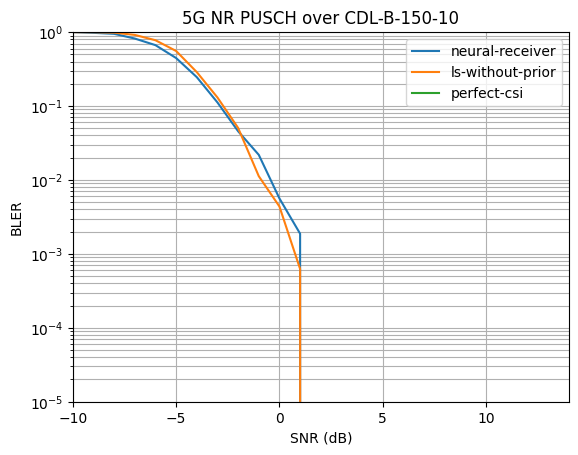

In [ ]:
print("Simulation duration: {:1.2f} [h]".format(PUSCH_SIMS["duration"]/3600))
for j, channel in enumerate(PUSCH_SIMS['channel_scenarios']):
    plt.figure()
    plt.title(f"5G NR PUSCH over {channel}")
    plt.xlabel("SNR (dB)")
    plt.ylabel("BLER")
    plt.grid(which="both")
    plt.xlim([PUSCH_SIMS['ebno_dbs'][0], PUSCH_SIMS['ebno_dbs'][-1]])
    plt.ylim([1e-5, 1.0])

    legend = []
    for i, decoding_scenario in enumerate(PUSCH_SIMS['decoding_scenarios']):
        plt.semilogy(PUSCH_SIMS['ebno_dbs'], PUSCH_SIMS["bler"][j * len(PUSCH_SIMS['decoding_scenarios']) + i], label=decoding_scenario)

    plt.legend()
    plt.show()